## MNIST Data

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

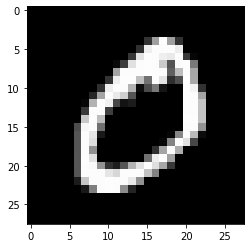

In [7]:
# pick a sample to plot
sample = 1
image = x_train[sample] # plot the sample
fig = plt.figure
plt.imshow(image.reshape(28,28), cmap='gray')
plt.show()

In [8]:
def plot_digits(images, labels, num_row, num_col):
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i].reshape(28,28), cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

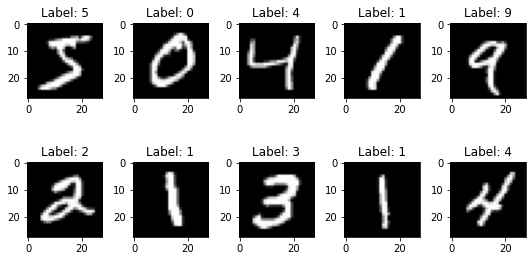

In [9]:
num_row = 2
num_col = 5
num = num_row * num_col
images = x_train[:num]
labels = y_train[:num]
plot_digits(images, labels, num_row, num_col)

## Autoencoder

In [10]:
# https://towardsdatascience.com/what-is-a-variational-autoencoder-9b41bd63f65e

In [11]:
from keras.layers import Dense, Input
from keras.models import Model

input_shape = (784,)
intermediate_dim = 32
latent_dim = 10

encoder_inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='intermediate_layer_1')(encoder_inputs)
x = Dense(intermediate_dim, activation='relu', name='intermediate_layer_2')(x)
latent_space = Dense(latent_dim, activation='relu', name='latent_space')(x)

encoder = Model(encoder_inputs, latent_space, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 intermediate_layer_1 (Dense  (None, 32)               25120     
 )                                                               
                                                                 
 intermediate_layer_2 (Dense  (None, 32)               1056      
 )                                                               
                                                                 
 latent_space (Dense)        (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras.layers import Dense, Input
from keras.models import Model

input_shape = (784,)
intermediate_dim = 32
latent_dim = 10

decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(intermediate_dim, activation='relu', name='intermediate_layer_3')(decoder_inputs)
reconstructed_inputs = Dense(input_shape[0], activation='relu', name='latent_space')(x)

decoder = Model(decoder_inputs, reconstructed_inputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 intermediate_layer_3 (Dense  (None, 32)               352       
 )                                                               
                                                                 
 latent_space (Dense)        (None, 784)               25872     
                                                                 
Total params: 26,224
Trainable params: 26,224
Non-trainable params: 0
_________________________________________________________________


In [13]:
import keras.backend as K

decoder_outputs = decoder(encoder(encoder_inputs))
autoencoder = Model(encoder_inputs, decoder_outputs, name='autoencoder')

def recon_loss(input_vols, output_vols):
    return K.mean((input_vols-output_vols)**2)

autoencoder.compile(optimizer='rmsprop', loss=recon_loss)

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 10)                26506     
                                                                 
 decoder (Functional)        (None, 784)               26224     
                                                                 
Total params: 52,730
Trainable params: 52,730
Non-trainable params: 0
_________________________________________________________________


## Variational Autoencoder (1)

In [14]:
# https://towardsdatascience.com/what-is-a-variational-autoencoder-9b41bd63f65e

In [15]:
%%script false --no-raise-error

import keras.backend as K
from keras.layers import Dense, Input, Lambda
from keras.models import Model

input_shape = (784,)
intermediate_dim = 32
latent_dim = 10
n_epoch = 10
m = 50 # batch size

inputs = Input(shape = input_shape, name = 'encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
mu = Dense(latent_dim, name='mu')(x)
log_var = Dense(latent_dim, name='log_sigma')(x)

def sample(a):
    mu, sigma = a
    epsilon = K.random_normal(shape=(1, latent_dim))
    return mu + K.exp(.5*log_var) * epsilon

z = Lambda(sample, output_shape=(latent_dim,), name='z')([mu, log_var])

encoder = Model(inputs, z, name='encoder')
encoder.summary()

Couldn't find program: 'false'


In [16]:
%%script false --no-raise-error

latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_shape[0], activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Couldn't find program: 'false'


In [17]:
%%script false --no-raise-error

import keras.backend as K

outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='VAE')

def vae_loss(input_vols, output_vols):
    beta = 1e-7
    kl_loss = K.sum(-1 - K.log(K.exp(log_var)) + K.exp(log_var) + K.square(mu))/2
    return K.mean((input_vols-output_vols)**2) + beta*kl_loss

vae.compile(optimizer='adam', loss=vae_loss) # 'rmsprop'

vae.summary()

Couldn't find program: 'false'


## Variational Autoencoder (2)

In [18]:
# Similar: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/

In [25]:
#from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.metrics import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
# import tensorflow as tf

input_dim = 784
intermediate_dim = 64
latent_dim = 16

batch_size = 50
n_epoch = 25

In [26]:
# Q(z|X) -- encoder
inputs = Input(shape=(input_dim,))
# h_q = Dense(intermediate_dim, activation='relu')(inputs)
h_q_1 = Dense(intermediate_dim, activation='relu')(inputs)
h_q = Dense(intermediate_dim/2, activation="relu")(h_q_1)
# h_q = Dense(intermediate_dim/2)(h_q_1)
# mu = Dense(latent_dim, activation='linear')(h_q)
mu = Dense(latent_dim)(h_q)
# log_sigma = Dense(latent_dim, activation='linear')(h_q)
log_sigma = Dense(latent_dim)(h_q)
encoder = Model(inputs, [mu, log_sigma])

In [27]:
# P(X|z) -- decoder
inp_z = Input(shape=(latent_dim,))
h_p = Dense(intermediate_dim, activation='relu')(inp_z)
# h_p = Dense(intermediate_dim)(inp_z)
outputs = Dense(input_dim, activation='sigmoid')(h_p)
# outputs = Dense(input_dim)(h_p)
decoder = Model(inp_z, outputs)

In [28]:
# Sample z ~ Q(z|X)
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

### encoder + decoder ###
mu, log_sigma = encoder(inputs)
z = Lambda(sample_z)([mu, log_sigma])
outputs = decoder(z)

In [29]:
def vae_loss(y_true, y_pred, log_sigma, mu):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    vae_loss = K.mean(recon + kl)
    return vae_loss

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)
vae.add_loss(vae_loss(inputs, outputs, log_sigma, mu))  # <======= add_loss
vae.compile(loss=None, optimizer='adam')
# vae.compile(optimizer='adam', loss=vae_loss) # doesn't work

In [40]:
n_epoch = 25
vae.fit(x_train, x_train,
        epochs=n_epoch,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, x_test))

Epoch 1/25
1200/1200 [==============================] - 4s 3ms/step - loss: 118.5211 - val_loss: 117.7930
Epoch 2/25
1200/1200 [==============================] - 4s 3ms/step - loss: 117.5378 - val_loss: 115.9314
Epoch 3/25
1200/1200 [==============================] - 4s 3ms/step - loss: 116.8389 - val_loss: 116.1239
Epoch 4/25
1200/1200 [==============================] - 4s 3ms/step - loss: 116.2441 - val_loss: 115.4317
Epoch 5/25
1200/1200 [==============================] - 4s 3ms/step - loss: 115.8268 - val_loss: 114.8351
Epoch 6/25
1200/1200 [==============================] - 4s 3ms/step - loss: 115.4267 - val_loss: 114.5218
Epoch 7/25
1200/1200 [==============================] - 4s 3ms/step - loss: 115.0681 - val_loss: 114.1444
Epoch 8/25
1200/1200 [==============================] - 4s 3ms/step - loss: 114.8040 - val_loss: 113.6853
Epoch 9/25
1200/1200 [==============================] - 4s 3ms/step - loss: 114.5166 - val_loss: 113.3190
Epoch 10/25
1200/1200 [=======================

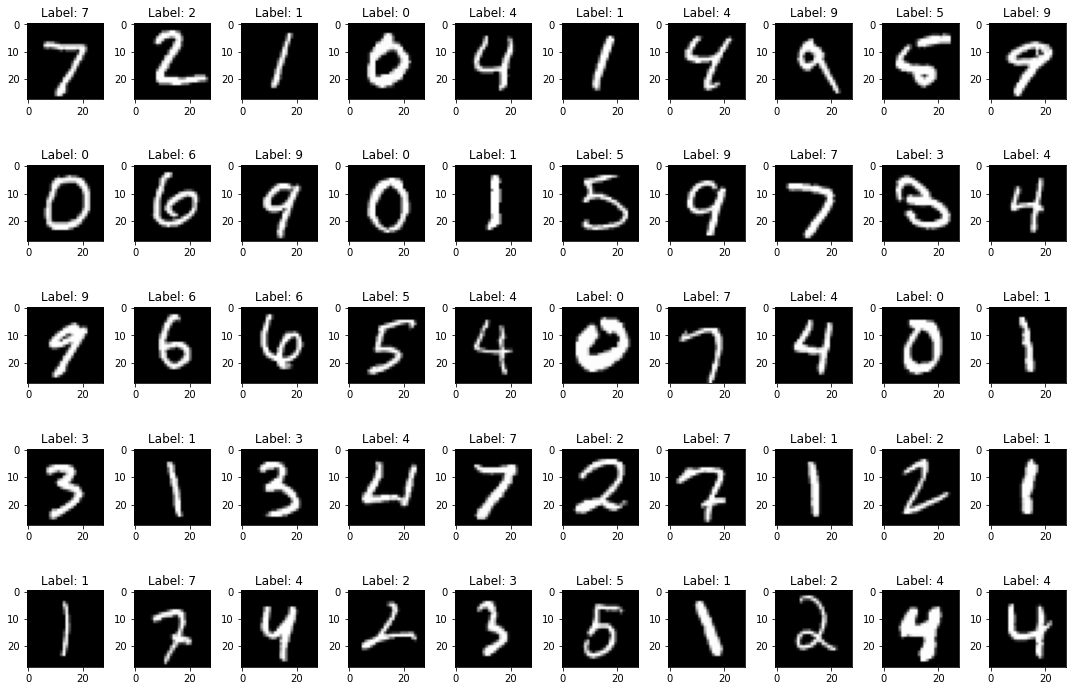

In [34]:
# encoder-decoder plot
num = batch_size
num_col = 10
num_row = batch_size // num_col
images = x_test[:num]
labels = y_test[:num]
plot_digits(images, labels, num_row, num_col)

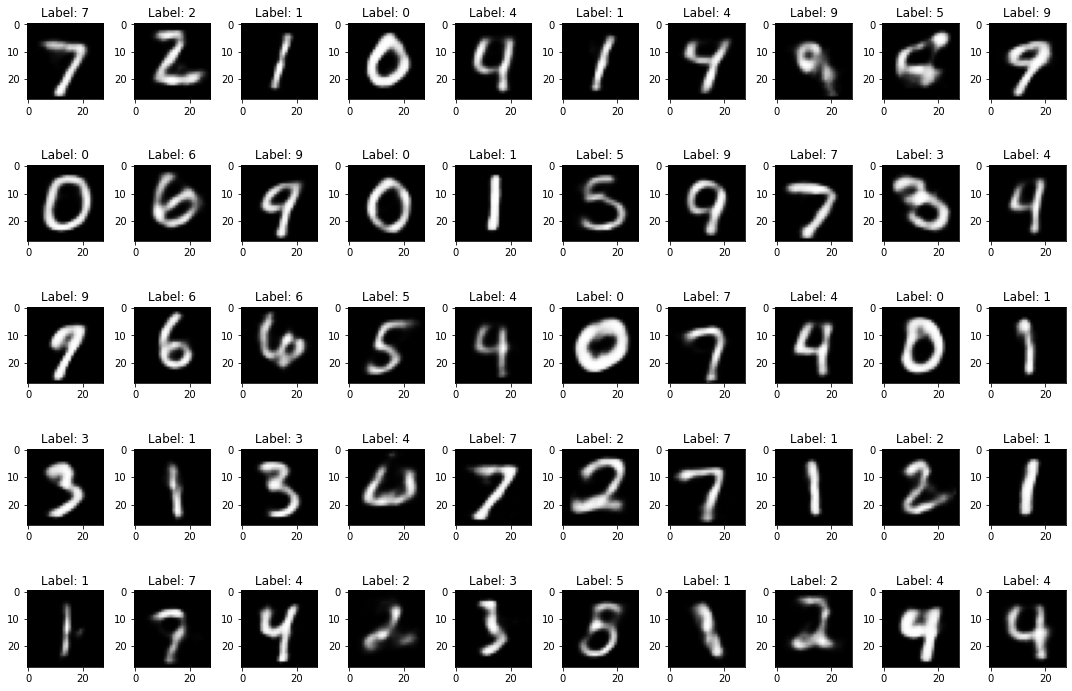

In [41]:
mu, log_sigma = encoder(images)
z = Lambda(sample_z)([mu, log_sigma])
outputs = decoder(z)
# outputs
plot_digits(outputs.numpy(), labels, num_row, num_col)

In [43]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

C:\Users\sjskd\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sjskd\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.040s...
[t-SNE] Computed neighbors for 60000 samples in 102.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

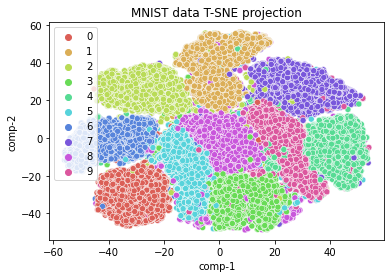

In [47]:
def tsne_plot(x_train, y_train):
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x_train)
    df = pd.DataFrame()
    df["y"] = y_train
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 10),
                    data=df).set(title="MNIST data T-SNE projection")
tsne_plot(x_train, y_train)

C:\Users\sjskd\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sjskd\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.002s...
[t-SNE] Computed neighbors for 60000 samples in 70.951s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

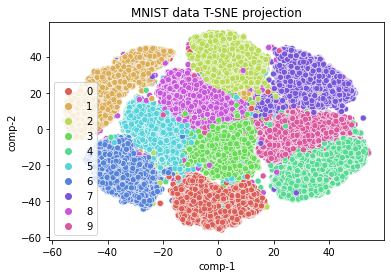

In [49]:
mu, log_sigma = encoder(x_train)
z = np.concatenate((mu.numpy(), log_sigma.numpy()), axis = 1)
tsne_plot(z, y_train)

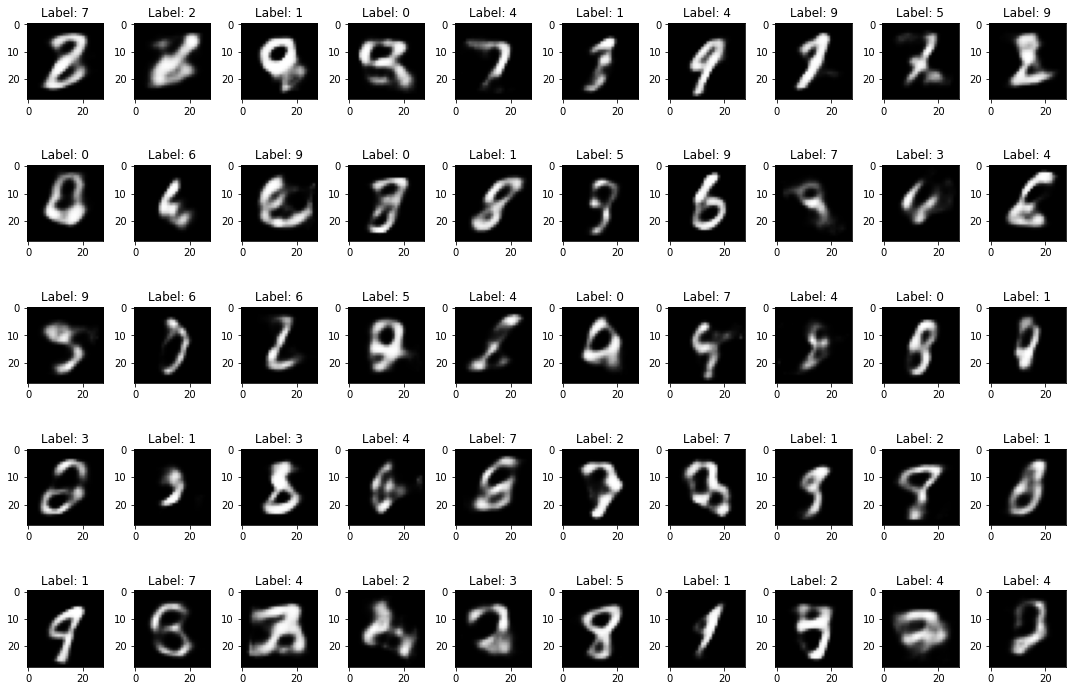

In [50]:
eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
outputs = decoder(eps)
labels = y_test[:batch_size]
plot_digits(outputs.numpy(), labels, num_row, num_col)

In [ ]:
import tensorflow as tf
n_features = 784
latent_dim = 10
m = 50 # batch size
n_z = 10
n_epoch = 10

In [ ]:

def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(x, x_decoded_mean, z_log_var, z_mean):
    xent_loss = K.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    vae_loss = K.mean(xent_loss + kl_loss)

    return vae_loss

def get_model():
    ### encoder ###
    
    inp = Input(shape=(n_features,))
    enc = Dense(64)(inp)
    
    z = Dense(32, activation="relu")(enc)
    z_mean = Dense(latent_dim)(z)
    z_log_var = Dense(latent_dim)(z)
            
    encoder = Model(inp, [z_mean, z_log_var])
    
    ### decoder ###
    
    inp_z = Input(shape=(latent_dim,))
    dec = Dense(64)(inp_z)

    out = Dense(n_features)(dec)
    
    decoder = Model(inp_z, out)   
    
    ### encoder + decoder ###
    
    z_mean, z_log_sigma = encoder(inp)
    z = Lambda(sampling)([z_mean, z_log_var])
    pred = decoder(z)
    
    vae = Model(inp, pred)
    vae.add_loss(vae_loss(inp, pred, z_log_var, z_mean))  # <======= add_loss
    vae.compile(loss=None, optimizer='adam')
    
    return vae, encoder, decoder

In [16]:
vae, encoder, decoder = get_model()

In [17]:
vae.fit(x_train, x_train,
        epochs=n_epoch,
        batch_size=m,
        shuffle=True,
        validation_data=(x_test, x_test))

Epoch 1/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.6473 - val_loss: 0.2993
Epoch 2/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.2874 - val_loss: 0.2818
Epoch 3/10
1200/1200 [==============================] - 3s 3ms/step - loss: 0.2821 - val_loss: 0.2810
Epoch 4/10
 840/1200 [====================>.........] - ETA: 0s - loss: 0.2823

KeyboardInterrupt: 